<a href="https://colab.research.google.com/github/rdose/ia3-hunger_games/blob/main/Final_model_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Model : XGBOOST
---


# LOS TRES TENSORES
- Pedro Dimas Martínez
- Juan Contell Husillos
- Rafael Domenech Serrano

# Starting point
---

In [1]:
import numpy as np
np.random.seed(989)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
url = "https://raw.githubusercontent.com/CuadraAlconero/IDAL_IA3_CuadraAlconero/main/hunger_data.csv"
dataframe = pd.read_csv(url, header=0)
dataframe.drop("Unnamed: 0", axis=1, inplace=True)
dataframe.columns = ["refractive_index", "sodium", "magnesium", "aluminum", "silicon", "potassium", "calcium", "barium", "iron", "type_of_glass"]

X = dataframe.drop(columns="type_of_glass") #Features
y = dataframe["type_of_glass"] #Target

X_train, X_test, y_train, y_test = train_test_split(X, y)

# The Model
---

We choosed a quite simply XGBoost Classifier for modeling this dataset predictions.

We've setted max_depth=5 for avoiding overfitting. There are other 3 params for providing XGBoost some kind of regularization: min_child_weight and gamma. Here's a post of Laurae that explains this overfitting avoiding parameters. https://www.kaggle.com/c/santander-customer-satisfaction/discussion/20662

In [3]:
from xgboost.sklearn import XGBClassifier

model_xgb = XGBClassifier(objective='multi:softmax',
                          num_class=6,
                          max_depth=5)

#Given the tiny amount of data left we can't afford to train the algorithm with a validation set :(
model_xgb.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=6, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

# Model release
---

Note the importance of saving this model trained under seed=989 because this seed grants us a right train/test splitting as is explained later.

In [4]:
import pickle

pickl = {'info' : " XGBOOST Classifier\n" +
                  " - Usage: install xgboost package and use with sklearn api:\n"
                  "      from xgboost.sklearn import XGBClassifier\n"
                  " - This model does not require any standarisation.\n" + 
                  " - Trained with " + str(X_train.shape[0]) + " samples\n" +
                  " - Tested with " + str(X_test.shape[0]) + " samples\n",
        'model': model_xgb}
pickle.dump(pickl, open('hg_los_tres_tensores'+'.p','wb'))


In [5]:
#Verify pickle
file_name = 'hg_los_tres_tensores.p'
with open(file_name,'rb') as pickled:
    data = pickle.load(pickled)
    infop =  data['info']
    modelp = data['model']
print(infop)
print(modelp)

 XGBOOST Classifier
 - Usage: install xgboost package and use with sklearn api:
      from xgboost.sklearn import XGBClassifier
 - This model does not require any standarisation.
 - Trained with 87 samples
 - Tested with 30 samples

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, num_class=6, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)


---
## Auxiliary functions
In order to execute this notebook the following cell needs to be executed before the previous cell. 

In [6]:
def print_scores(model, X_train, X_test, Y_train, Y_test, model_name='[no name]'):
    from sklearn.metrics import f1_score, balanced_accuracy_score

    Y_pred = model.predict(X_test)
    print(" "*15,model_name)
    print("Default score:","-"*70)
    print(" Train: %.3f" % model.score(X_train, Y_train))
    print(" Test: %.3f" % model.score(X_test, Y_test))
    print("Other scores:","-"*70)
    print(" "*12,model.classes_)
    print(" F1: ", f1_score(Y_test,Y_pred,average=None))
    print(" Balanced accuracy: %.3f" % balanced_accuracy_score(Y_test,Y_pred))
    print("-"*85)

def plot_roc(model, X_test, Y_test):
    from sklearn.metrics import roc_curve, roc_auc_score, auc
    
    from scipy import interp
    import matplotlib.pyplot as plt
    from itertools import cycle
    from sklearn.preprocessing import label_binarize    # Let's binarise the classes


    new_probs = label_binarize(Y_test, classes=[1, 2, 3, 5, 6, 7])

    y_score = model.predict_proba(X_test) #model.decision_function(X_test)
    n_classes = len(model.classes_)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(new_probs[:, i], list(model.predict_proba(X_test)[:, i]), drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])
      
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Plot all ROC curves
    plt.figure(figsize=(10,8))

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'limegreen', 'darkorchid', 'peru'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(model.classes_[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for each class')
    plt.legend(loc="lower right")
    plt.show()

## Model performance
---

                [ XGBOOST PICKLED]
Default score: ----------------------------------------------------------------------
 Train: 0.943
 Test: 0.933
Other scores: ----------------------------------------------------------------------
             [1 2 3 5 6 7]
 F1:  [0.93333333 0.88888889 1.         1.         1.        ]
 Balanced accuracy: 0.960
-------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


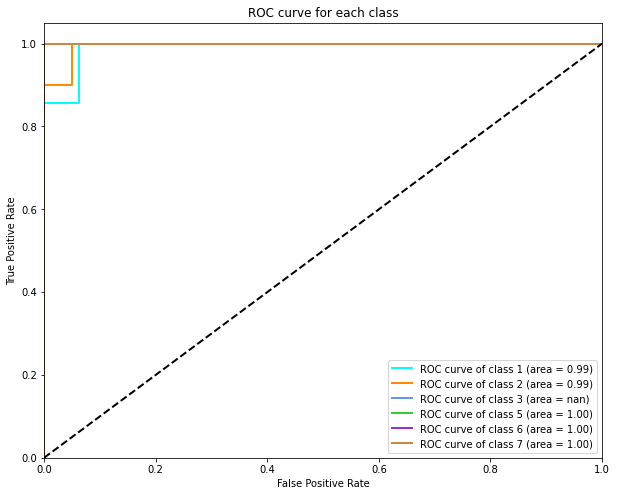

In [7]:
np.random.seed(123)

X = dataframe.drop(columns="type_of_glass") #Features
y = dataframe["type_of_glass"] #Target

X_train, X_test, y_train, y_test = train_test_split(X, y)


print_scores(modelp, X_train, X_test, y_train, y_test, '[ XGBOOST PICKLED]')
plot_roc(modelp, X_test, y_test)



In [ ]:
ºº

# Summary of models and strategies that we've tried:
---

## Develop path 

We started with an analisys of our dataframe. We checked nulls and made some feature representation. Also, we choosed the right seed for achieveing a nice train/test spliting. We needed our train/test split to contain at least one sample of each class so then we could assert that our score results are rights. 

Once we had our dataframe described and a right train/test split we set a default logistic regression model as benchmark. At first we started using a decission tree model as benchmark, but we realized that it needed some hyperparameter tunning because decission trees always overfits the model. 

Then, each contributor took his own developing path and we compared results frequently. You can see the whole development process on draft folder of this repo.

### Normalization



We tried a wide variety of normalizations but no one guided us to a significant better results than benchmark ones

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression

def normalize_and_print_score(scaler, model, X_train, X_test, Y_train, Y_test, model_name=""):
  X_train_norm = X_train.copy()
  X_test_norm = X_test.copy()

  X_train_norm = scaler.fit_transform(X_train)
  X_test_norm = scaler.transform(X_test)
  
  model.fit(X_train_norm, Y_train)
  print_scores(model, X_train_norm, X_test_norm, Y_train, Y_test, model_name)

def relative_norm(df):
  norm_df = df.copy()
  for i in range(len(norm_df)):
    norm_df.iloc[i,:] = norm_df.iloc[i,:]/norm_df.iloc[0,:].sum()
  return norm_df

model = LogisticRegression(max_iter=1500)

scaler = StandardScaler()
normalize_and_print_score(scaler, model, X_train, X_test, y_train, y_test, model_name="LOG REG STD SCALER")

scaler = MinMaxScaler()
normalize_and_print_score(scaler, model, X_train, X_test, y_train, y_test, model_name="LOG REG MINMAX SCALER")

scaler = RobustScaler()
normalize_and_print_score(scaler, model, X_train, X_test, y_train, y_test, model_name="LOG REG ROBUST SCALER")

scaler = PowerTransformer()
normalize_and_print_score(scaler, model, X_train, X_test, y_train, y_test, model_name="LOG REG POWER TRANSFORMER")

X_train_norm = relative_norm(X_train)
X_test_norm = relative_norm(X_test)
model = LogisticRegression(max_iter=15000).fit(X_train_norm, y_train)
print_scores(model, X_train_norm, X_test_norm, y_train, y_test, model_name="LOG REG RELATIVE NORM")

model = LogisticRegression(max_iter=15000).fit(X_train, y_train)
print_scores(model, X_train, X_test, y_train, y_test, model_name="BENCHMARK: LOG REG")

                LOG REG STD SCALER
Default score: ----------------------------------------------------------------------
 Train: 0.713
 Test: 0.633
Other scores: ----------------------------------------------------------------------
             [1 2 3 5 6 7]
 F1:  [0.66666667 0.6        0.         0.         1.         0.85714286]
 Balanced accuracy: 0.599
-------------------------------------------------------------------------------------
                LOG REG MINMAX SCALER
Default score: ----------------------------------------------------------------------
 Train: 0.540
 Test: 0.667
Other scores: ----------------------------------------------------------------------
             [1 2 3 5 6 7]
 F1:  [0.75862069 0.57142857 0.         0.         0.75      ]
 Balanced accuracy: 0.427
-------------------------------------------------------------------------------------
                LOG REG ROBUST SCALER
Default score: ---------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


                LOG REG RELATIVE NORM
Default score: ----------------------------------------------------------------------
 Train: 0.667
 Test: 0.633
Other scores: ----------------------------------------------------------------------
             [1 2 3 5 6 7]
 F1:  [0.68965517 0.52631579 0.         1.         0.75      ]
 Balanced accuracy: 0.593
-------------------------------------------------------------------------------------
                BENCHMARK: LOG REG
Default score: ----------------------------------------------------------------------
 Train: 0.644
 Test: 0.633
Other scores: ----------------------------------------------------------------------
             [1 2 3 5 6 7]
 F1:  [0.68965517 0.52631579 0.         0.         1.         0.85714286]
 Balanced accuracy: 0.593
-------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


### 1vsRest

We observed that there were models based on decission trees, which could perform a good classification but they ussually didn't get a good classification for one concrete class. We thought that could try to classify first one class and then train model for predict the rest of classes.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def to_1_vs_all(Y, class_num):
  Y_class = Y.copy()
  Y_class[Y_class == class_num] = 0
  Y_class[(Y_class != class_num) & (Y_class != 0)] = 1
  return Y_class

Y_train_class3 = to_1_vs_all(y_train, 3)
Y_test_class3 = to_1_vs_all(y_test, 3)

model1 = DecisionTreeClassifier(criterion="entropy", max_depth=15, min_samples_leaf=3).fit(X_train, Y_train_class3)

X_class3 = X_train.copy()
X_class3['y_pred'] = model1.predict(X_class3)

mask = X_class3['y_pred']!=0
X_class3 = X_class3[mask]
X_class3.drop(columns='y_pred', inplace=True)
Y_class3 = y_train[mask]

model2 = DecisionTreeClassifier(criterion="entropy", max_depth=15, min_samples_leaf=3).fit(X_class3, Y_class3)  
print_scores(model2, X_train, X_test, y_train, y_test, "1vsRest class3")

                1vsRest class3
Default score: ----------------------------------------------------------------------
 Train: 0.782
 Test: 0.733
Other scores: ----------------------------------------------------------------------
             [1 2 3 5 6 7]
 F1:  [0.72727273 0.72       0.5        1.         0.85714286]
 Balanced accuracy: 0.844
-------------------------------------------------------------------------------------


### Some of the other models considered
#### Random Forest
Extensive manual tweaking and gridsearch was performed. The most important parameters to change from default for this algorithm and dataset appeared to be:
- `class_weight`. Best result obtained using a `'balanced'` class weight
- `max_depth`. A maximum depth of about 30 seemed to provide the best results
- `min_samples_split`. A minimum number of samples required to split an internal node of 3 was observed to be the best choice

The best score obtained with this model has been a balanced accuracy of  0.73